# TTS any(ish) language pipeline

*Before starting please select ttsvenv as the environment where your kernel will run*

## Set GPU to run the training

In [1]:
# Step 1: Import the necessary library
import os

# Step 2: Set the environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Step 3: Verify the setting (optional)
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"])

# Now you can continue with the rest of your notebook,
# and any CUDA-enabled operations will use GPU 0.


CUDA_VISIBLE_DEVICES: 0


## Install dependencies 

In [2]:
%pip install -r requirements.txt

  Using cached Cython-3.0.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached packaging-24.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached pandas-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached PyYAML-6.0.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu121 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1)
ERROR: No matching distribution found for torch==2.3.0+cu121
Note: you may need to restart the kernel to use updated packages.


# Function to switch to a given path

In [3]:
import os
base_path = os.getcwd()
def change_to_base_directory(base_path):

    # Obtener el directorio actual
    current_directory = os.getcwd()

    # Comprobar si el directorio actual es el deseado
    if current_directory == base_path:
        print("You already are on:", base_path)
    else:
        print("Changing to:", base_path)
        os.chdir(base_path)  # Cambiar al directorio deseado
        print("New path:", os.getcwd())

In [4]:
#If you store your token as a secret named "HF_TOKEN" in Colab, you don't need to do this.

from huggingface_hub import notebook_login

notebook_login()

# Set parameters

In [5]:
import datetime
from tqdm import tqdm

In [6]:
lang = "sw"
lang_iso = "swh"
text_field = "sentence"
speaker_field = "client_id"
audio_field = "audio"
sample_text_to_generate = "Hapo mwanzo alikuwako Neno, huyo Neno alikuwa pamoja na Mungu, naye Neno alikuwa Mungu.".lower()
date_string = datetime.datetime.now().strftime("%Y%m%d")
output_dir = f"data/SIL/TTS-{lang_iso}-{date_string}" #change date_string if resuming training

# Evaluate audio dataset

This cell will download the dataset, if there's already files on data/content/cache, it won't download anything again, but if for some reason you need to redownload it, you can add an option to load_dataset:

download_mode='force_redownload'

In [7]:
from datasets import load_dataset, Audio

import os

cache_dir = 'data/content/cache'
dataset = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="train+validation+test+other", token=True, trust_remote_code=True, cache_dir = cache_dir) # streaming = True ?
len(dataset)

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 21397it [00:00, 213962.04it/s]
Reading metadata...: 46209it [00:00, 208792.98it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 12231it [00:00, 216759.76it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 12234it [00:00, 230125.33it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 12245it [00:00, 122443.40it/s]
Reading metadata...: 32836it [00:00, 171535.84it/s]
Reading metadata...: 53592it [00:00, 187979.97it/s]
Reading metadata...: 74404it [00:00, 195927.90it/s]
Reading metadata...: 94899it [00:00, 199178.40it/s]
Reading metadata...: 115991it [00:00, 203166.22it/s]
Reading metadata...: 136931it [00:00, 205201.63it/s]
Reading metadata...: 157522it [00:00, 205424.85it/s]
Reading metadata...: 178065it [00:00, 203767.95it/s]
Reading metadata...: 198951it [00:01, 205328.95it/s]
Reading metadata...: 219691it [00:01, 205957.68it/s]
Reading metadata...: 240531it [00:01, 206697.20it/s]
Reading metadata...: 261543it [00:01, 207728.57it/s]
Reading metadata...: 282318it [00:01, 206285.82it/s]
Reading metadata...: 302950it [00:01, 202911.35it/s]
Reading metadata...: 323254it [00:01, 200007.00it/s]
Reading metadata...: 343269it [00:01, 199421.58it/s]
Reading metadata...: 376717it [00:01, 199333.75it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 22395it [00:00, 223935.26it/s]
Reading metadata...: 44789it [00:00, 222192.55it/s]
Reading metadata...: 79915it [00:00, 216134.46it/s]


447391

In [8]:
from datasets import load_dataset, Audio

In [9]:
dataset[0] #identify the text field and speaker fields

{'client_id': 'c32b6889700b2aadf1b5524c64abc2e06de0769c68ba330ed38e9b96144db8e109ce609b1ca1e7687432640e29cdd3b3d02a00bd895036703dbc2aba7610b30c',
 'path': '/home/aquintero/TTSModel/ORU-Titan-example/TTS/data/content/cache/downloads/extracted/e89cd6ff2c562d47839d90b56fd33d5cc0616eafaf9e20da1a0f135fd1f34361/sw_train_0/common_voice_sw_30574257.mp3',
 'audio': {'path': '/home/aquintero/TTSModel/ORU-Titan-example/TTS/data/content/cache/downloads/extracted/e89cd6ff2c562d47839d90b56fd33d5cc0616eafaf9e20da1a0f135fd1f34361/sw_train_0/common_voice_sw_30574257.mp3',
  'array': array([ 7.10542736e-14,  7.67386155e-13,  1.16529009e-12, ...,
          1.15293165e-06, -1.70660769e-06, -2.12845816e-06]),
  'sampling_rate': 48000},
 'sentence': 'blob anapenda kutembea usiku kuliko mchana',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'twenties',
 'gender': 'female',
 'accent': '',
 'locale': 'sw',
 'segment': '',
 'variant': ''}

In [10]:
import IPython.display as ipd

ipd.Audio(dataset[0]['path'])

In [11]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=8000))

# Create vocab for tokenizer

In [12]:
def extract_all_chars(batch):
    all_text = " ".join(batch[text_field])
    vocab = list(set(all_text.lower()))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])


Map:   0%|          | 0/447391 [00:00<?, ? examples/s]

In [13]:
dataset_counts = {k: vocabs['all_text'][0].lower().count(k) for k in dataset_vocab}
rare_counts = {k: v for k, v in dataset_counts.items() if v < .00002 * len(vocabs['all_text'][0])}
non_rare_counts = {k: v for k, v in dataset_counts.items() if v >= .00002 * len(vocabs['all_text'][0])}
vocab_length = len(list(non_rare_counts.keys()))

In [14]:
print(dataset_vocab)
print(dataset_counts)
print(rare_counts)
print(non_rare_counts)
print(vocab_length)

{'ô', 'á', '.', 'u', 'ł', '’', 'q', '!', 'o', 'é', '“', 's', 'י', 'd', '(', 'ı', 'î', '"', 'ñ', 'ū', 'w', 'g', 'ç', ' ', 'r', ',', "'", 'š', '”', ';', 'à', 'ó', '_', '#', 'ا', 'ą', '½', 't', 'y', 'í', 'ạ', 'ũ', 'å', '…', 'µ', '\\', '*', ':', '`', 'ā', 'j', '-', '–', 'ü', ']', '/', 'k', 'ã', 'n', 'v', 'a', 'm', 'ï', 'ː', '°', ')', 'l', 'x', '=', 'ụ', 'è', 'c', 'f', 'ọ', 'ø', 'ʿ', 'b', 'p', '•', 'ö', 'â', 'i', '?', 'z', 'h', '‘', 'ê', 'ë', 'μ', 'ú', 'e'}
{'ô': 30, 'á': 40, '.': 244757, 'u': 1343068, 'ł': 2, '’': 515, 'q': 922, '!': 433, 'o': 807532, 'é': 46, '“': 425, 's': 591587, 'י': 3, 'd': 364330, '(': 168, 'ı': 2, 'î': 4, '"': 11942, 'ñ': 26, 'ū': 25, 'w': 883571, 'g': 315724, 'ç': 6, ' ': 4056024, 'r': 393883, ',': 51828, "'": 1845, 'š': 1, '”': 272, ';': 455, 'à': 3, 'ó': 117, '_': 56, '#': 4, 'ا': 3, 'ą': 5, '½': 3, 't': 664642, 'y': 566159, 'í': 43, 'ạ': 27, 'ũ': 27, 'å': 2, '…': 6, 'µ': 83, '\\': 20, '*': 1, ':': 1217, '`': 18, 'ā': 3, 'j': 262925, '-': 11366, '–': 54, 'ü': 32,

In [15]:
# manually create a list to re-assign rare_counts to non_rare_counts ... allow the list to grow ... if you need to keep something on the left side for your language, add it to the keep_list.
# Any symbols which should cause the whole sentence to be rejected should be added to the reject_list
replacements = [
    ("à", "a"), ("á", "a"), ("â", "a"), ("ã", "a"), ("ã", "a"), ("å", "a"), ("å", "a"), ("ạ", "a"), ("ã", "a"),("å", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ó", "o"),
    ("ô", "o"),
    ("õ", "o"),
    ("ú", "u"),
    ("û", "u"),
    ("ü", "u"),
    ("ū", "u"),
    ("ụ", "u"),
    ("ũ", "u"),
    ("ý", "y"),
    ("ÿ", "y"),
    ("ñ", "n"),
    ('š', 's'), ('š', 's'),("š", "s"),
    ('ž', 'z'),
    ('ø', 'o'),
    ('”', '"'),
    ('“', '"'),
    ('’', "'"),
    ('‘', "'"),
    ('`', "'"),
    (':', "."),
    (';', ","),
    ('!', "."),
    ('?', "."),
    ('–', '-'),
    ('-', ""),
    ('\\', ""),
    ('/', ""),
    ('(', ""),
    (')', ""),
    ('*', ''),
    ("µ", ''),
    ("µ", ''),
    ('…', '.'),
    ("ː", ''),
    ("μ", ''),

]

print(set(list(rare_counts.keys())) - set([x[0] for x in replacements]))

{'=', 'ā', '_', 'ọ', 'é', 'ı', 'ʿ', '#', 'ا', 'ą', 'י', '•', '½', 'ł', ']', '°', 'î', 'ê'}


In [16]:


keep_list = ['?', '-']
reject_list = ["µ", "µ", "ː", 'ø', 'š']

def reject_sample(inputtext):
    for reject in reject_list:
        if reject in inputtext:
            return False
    return True

def cleanup_text(inputs):
    for src, dst in replacements:
      if src not in keep_list:
        inputs[text_field] = inputs[text_field].replace(src, dst)
    return inputs

dataset = dataset.filter(reject_sample, input_columns=[text_field])
dataset = dataset.map(cleanup_text)
dataset = dataset.map(cleanup_text)

Filter:   0%|          | 0/447391 [00:00<?, ? examples/s]

Map:   0%|          | 0/447218 [00:00<?, ? examples/s]

Map:   0%|          | 0/447218 [00:00<?, ? examples/s]

In [17]:
def lower_case(inputs):
  inputs[text_field] = inputs[text_field].lower()
  return inputs

dataset = dataset.map(lower_case)

Map:   0%|          | 0/447218 [00:00<?, ? examples/s]

In [18]:
vocab = {list(non_rare_counts.keys())[i]: i for i in range(len(list(non_rare_counts.keys())))}
print(vocab)

{'.': 0, 'u': 1, '’': 2, 'q': 3, 'o': 4, 's': 5, 'd': 6, '"': 7, 'w': 8, 'g': 9, ' ': 10, 'r': 11, ',': 12, "'": 13, 't': 14, 'y': 15, ':': 16, 'j': 17, '-': 18, 'k': 19, 'n': 20, 'v': 21, 'a': 22, 'm': 23, 'l': 24, 'x': 25, 'c': 26, 'f': 27, 'b': 28, 'p': 29, 'i': 30, '?': 31, 'z': 32, 'h': 33, 'e': 34}


In [19]:
import json

with open("vocab.json", "w") as f:
    json.dump(vocab, f)

# Filter speakers

In [20]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset[speaker_field]:
    speaker_counts[speaker_id] += 1

In [21]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


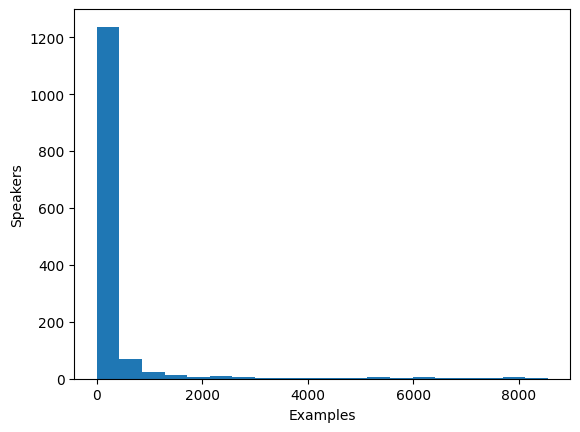

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [23]:
#filter down total number of speakers based on above histogram
def select_speaker(speaker_id):
    return 300 <= speaker_counts[speaker_id] <= 1000


dataset = dataset.filter(select_speaker, input_columns=[speaker_field])

Filter:   0%|          | 0/447218 [00:00<?, ? examples/s]

# Number of Speakers

In [24]:
num_speakers = len(set(dataset[speaker_field]))
print(f"Number of speakers: {num_speakers}")
print(f"Length of dataset: {len(dataset)}")

Number of speakers: 146
Length of dataset: 77412


# Prepare data for training

In [25]:
def add_source_and_license(inputs):
  inputs['source'] = 'mozilla-foundation/common_voice_16_1'
  inputs['license'] = 'CC-0'
  return inputs

dataset = dataset.map(add_source_and_license)
dataset[0]

Map:   0%|          | 0/77412 [00:00<?, ? examples/s]

{'client_id': '39e93dddcd981ea59b709adbfdb74bf6e3556234d56ca47e03bf3da7b84d523eaf3c3dedf816128187ca472606a069d8c6af4d395b42e247aeb826d314a39550',
 'path': '/home/aquintero/TTSModel/ORU-Titan-example/TTS/data/content/cache/downloads/extracted/e89cd6ff2c562d47839d90b56fd33d5cc0616eafaf9e20da1a0f135fd1f34361/sw_train_0/common_voice_sw_35163757.mp3',
 'audio': {'path': '/home/aquintero/TTSModel/ORU-Titan-example/TTS/data/content/cache/downloads/extracted/e89cd6ff2c562d47839d90b56fd33d5cc0616eafaf9e20da1a0f135fd1f34361/sw_train_0/common_voice_sw_35163757.mp3',
  'array': array([-5.09317033e-11,  0.00000000e+00,  1.27329258e-11, ...,
          1.44743353e-07,  1.35469236e-07, -2.63554284e-07]),
  'sampling_rate': 8000},
 'sentence': 'alipata pesa kwa njia halali',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'sw',
 'segment': '',
 'variant': '',
 'source': 'mozilla-foundation/common_voice_16_1',
 'license': 'CC-0'}

In [26]:
dataset = dataset.train_test_split(test_size=0.1)

# Pushing dataset generated to hub

## ⚠️ Only run when needed##

This next step only needs to be done when there's an update to the dataset.

If the dataset has not been updated, run the previous steps (Run Before), then skip this step and continue running subsequent steps.

In [27]:
#dataset.push_to_hub(f'sil-ai/{lang_iso}-tts-training-data', private=True, token=True)

## 🤗 Define Empty Vits model

The steps in this section only apply for the 🤗 **Hugging Face** approach.

In [28]:
#from transformers import VitsTokenizer, VitsConfig, VitsModel

#tokenizer = VitsTokenizer('vocab.json', pad_token = '<pad>', unk_token = '<unk>', language = lang_iso, add_blank = False,
#                          normalize = False, phonemize = False, is_uroman = False)


#config = VitsConfig.from_pretrained("ylacombe/vits-vctk-with-discriminator")
#config.num_speakers = num_speakers
#config.vocab_size = vocab_length
#model = VitsModel(config)

# Pushing model and tokenizer to Hub

In [29]:
#model.push_to_hub('sil-ai/base-vits-intialization', private=True, token=True)  #Feel free to overwrite as necessary

In [30]:

#tokenizer.push_to_hub(f"sil-ai/tts-{lang_iso}-vits", private=True, token=True)

# Double check dataset

In [31]:
#from datasets import load_dataset
#from transformers import VitsTokenizer, VitsModel

#dataset = load_dataset(f'sil-ai/{lang_iso}-tts-training-data')
#tokenizer = VitsTokenizer.from_pretrained(f"sil-ai/tts-{lang_iso}-vits")
#model = VitsModel.from_pretrained('sil-ai/base-vits-intialization', token=True)

In [32]:
#from tqdm import tqdm

#float_max = -10000000.0
#float_min = 10000000.0

#for item in tqdm(dataset['train']):
#  if max(item['audio']['array']) > float_max:
#    float_max = max(item['audio']['array'])
#  if min(item['audio']['array']) < float_min:
#    float_min = min(item['audio']['array'])

#print(float_max, float_min)

In [33]:
#import IPython
#import numpy as np

#IPython.display.Audio(dataset['train'][0]['audio']['array'], rate = dataset['train'][0]['audio']['sampling_rate'])

In [34]:
#test_aud = dataset['train'][0]['audio']['array']/np.max(np.abs(dataset['train'][0]['audio']['array']))

#IPython.display.Audio(test_aud, rate= 22050)

In [35]:
#This should find no examples. If it does, rerun filtering and dataset hub push above.

#from tqdm import tqdm
#for split in dataset.keys():
#  for i in tqdm(range(len(dataset[split]))):
#    try:
#      tokenizer(dataset[split][i]['sentence'], return_tensors='pt')
#    except:
#      print(split, i)
#      print(dataset[split][i]['sentence'])
#      continue

In [36]:
#if needed ...
#dataset = dataset.map(cleanup_text)

In [37]:
# when confirmed working
#dataset.push_to_hub(f'sil-ai/{lang_iso}-tts-training-data', private=True, token=True)

# Train with Coqui, convert to HuggingFace?

In [38]:
import datetime
from tqdm import tqdm

# Creating TTS manifest file

The manifest is a file that will contain the metadata of the audios we are going to use, including their path and their transcriptions, it also separates between train and test.

In [40]:
# Load the dataset
from datasets import load_dataset
import json, os
import torchaudio, torch

dataset = load_dataset(f'sil-ai/{lang_iso}-tts-training-data', cache_dir = cache_dir)

In [41]:

tts_manifest = []

for split in ['train', 'test']:
    for item in tqdm(dataset[split]):
        aud = torch.from_numpy(item['audio']['array'])
        aud = aud.type(torch.float32)
        aud = aud.unsqueeze(0)
        saveas = os.path.join(cache_dir, item['path'].replace('.mp3', '.wav'))
        os.makedirs(os.path.dirname(saveas), exist_ok=True)
        torchaudio.save(saveas, aud, sample_rate=8000, channels_first=True)
        tts_manifest.append({
            'text': item['sentence'],
            'speaker_name': item['client_id'],
            'root_path': os.path.dirname(item['path']),
            'audio_file': os.path.basename(item['path']).replace('.mp3', '.wav')
        })

# Optionally, save the manifest to a JSON file
with open('tts_manifest.json', 'w') as f:
    json.dump(tts_manifest, f, indent=4)


  0%|          | 0/24471 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

In [42]:
aud.shape

torch.Size([1, 134946])

In [43]:
output_dir= 'data/content/cache/downloads/extracted'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir,'tts_manifest.json'), 'w') as f:
  json.dump(tts_manifest, f, indent=2)

In [44]:
tts_manifest[0]

{'text': 'kukusanya taarifa kunatakiwa uweredi mkubwa sana',
 'speaker_name': '6370d4536d7033b81e4957d1c9671efa1c82e1ac2dac6c36afa4487eeb64a89dc160709def5d6a4bea275f21b117533c5c2451c6e1ffba42551ba9c2479d2706',
 'root_path': '/home/aquintero/ORU-new/hudlow debug/data/content/cache/downloads/extracted/3341b1a6624eed9cb2623ab7e29e8710d84ac07a2c689e11fef015bb21556e19/sw_train_0',
 'audio_file': 'common_voice_sw_35438504.wav'}

In [45]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# TTS Import

In [48]:
change_to_base_directory(base_path)
%cd ttsvenv/lib/python3.11/site-packages

import os
import json

from trainer import Trainer, TrainerArgs

from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.configs.vits_config import VitsConfig
from TTS.tts.models.vits import CharactersConfig, Vits, VitsArgs, VitsAudioConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.models.vits import Vits, VitsAudioConfig
from TTS.tts.utils.text.tokenizer import TTSTokenizer
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.speakers import SpeakerManager

You already are on: /home/aquintero/ORU-new/hudlow debug
/home/aquintero/ORU-new/hudlow debug/ttsvenv/lib/python3.11/site-packages


In [49]:
def ispunct(ch):
    return ch in string.punctuation

In [50]:
dataset['train'][0]

{'client_id': '6370d4536d7033b81e4957d1c9671efa1c82e1ac2dac6c36afa4487eeb64a89dc160709def5d6a4bea275f21b117533c5c2451c6e1ffba42551ba9c2479d2706',
 'path': '/home/aquintero/ORU-new/hudlow debug/data/content/cache/downloads/extracted/3341b1a6624eed9cb2623ab7e29e8710d84ac07a2c689e11fef015bb21556e19/sw_train_0/common_voice_sw_35438504.mp3',
 'audio': {'path': 'common_voice_sw_35438504.mp3',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.99177407e-05, -4.38742500e-05, -7.40317046e-06]),
  'sampling_rate': 22050},
 'sentence': 'kukusanya taarifa kunatakiwa uweredi mkubwa sana',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'twenties',
 'gender': 'female',
 'accent': '',
 'locale': 'sw',
 'segment': '',
 'variant': '',
 'source': 'mozilla-foundation/common_voice_16_1',
 'license': 'CC-0'}

# Paths

In [51]:
from posixpath import join
import string

# set experiment paths
output_path = output_dir
dataset_path = '/'.join(os.path.dirname(dataset['train'][0]['path']).split('/')[:-2])
manifest_file ='tts_manifest.json'

In [52]:
%pip install numpy --upgrade
%pip install tensorboard==2.15.0

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorboard-2.15.0-py3-none-any.whl.metadata (1.7 kB)
Using cached tensorboard-2.15.0-py3-none-any.whl (5.6 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.0
    Uninstalling tensorboard-2.16.0:
      Successfully uninstalled tensorboard-2.16.0
Note: you may need to restart the kernel to use updated packages.


# Resampling script

With this code you can resample the datasat, the default sample rate from the mozilla datasets is 48000, but you may need a lower one to train the models, the lower, the faster. THe minimum is 8000, and even there the resample can take up to 3 hours. It is important to let the process run with out interrupting it, since in that case some audios would have been resampled and others would have not, which affects integrity

In [49]:
base_path

'/home/aquintero/TTSModel/ORU-Titan-example/TTS'

In [ ]:
change_to_base_directory(base_path)
dataset_path = 'data/content/cache/downloads/extracted'
!python ttsvenv/lib/python3.11/site-packages/TTS/bin/resample.py --input_dir $dataset_path --output_sr 8000 --file_ext mp3

You already are on: /home/aquintero/TTSModel/ORU-Titan-example/TTS
Resampling the audio files...
Found 527306 files...
  0%|                                                | 0/527306 [00:00<?, ?it/s]

# GlowTTS Model

In [ ]:
# Trainer: Where the ✨️ happens.
# TrainingArgs: Defines the set of arguments of the Trainer.
from trainer import Trainer, TrainerArgs

# GlowTTSConfig: all model related values for training, validating and testing.
from TTS.tts.configs.glow_tts_config import GlowTTSConfig

from TTS.config.shared_configs import BaseAudioConfig
# BaseDatasetConfig: defines name, formatter and path of the dataset.
from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.models.glow_tts import GlowTTS
from TTS.tts.utils.text.tokenizer import TTSTokenizer
from TTS.utils.audio import AudioProcessor


# DEFINE DATASET CONFIG
# Set LJSpeech as our target dataset and define its path.
# You can also use a simple Dict to define the dataset and pass it to your custom formatter.

dataset_config = BaseDatasetConfig(
    formatter='vctk', meta_file_train=manifest_file, path=dataset_path
)
# ❗ resample the dataset externally using `TTS/bin/resample.py` and set `resample=False` for faster training
audio_config = BaseAudioConfig(
    sample_rate=8000
)

# INITIALIZE THE TRAINING CONFIGURATION
# Configure the model. Every config class inherits the BaseTTSConfig.
config = GlowTTSConfig(
    batch_size=32,
    audio=audio_config,
    eval_batch_size=16,
    num_loader_workers=4,
    num_eval_loader_workers=4,
    run_eval=True,
    test_delay_epochs=-1,
    epochs=1000,
    text_cleaner="phoneme_cleaners",
    use_phonemes=True,
    phoneme_language="en-us",
    phoneme_cache_path=os.path.join(output_path, "phoneme_cache"),
    print_step=25,
    print_eval=False,
    mixed_precision=True,
    output_path=output_path,
    datasets=[dataset_config],
)

# INITIALIZE THE AUDIO PROCESSOR
# Audio processor is used for feature extraction and audio I/O.
# It mainly serves to the dataloader and the training loggers.
ap = AudioProcessor.init_from_config(config)

# INITIALIZE THE TOKENIZER
# Tokenizer is used to convert text to sequences of token IDs.
# If characters are not defined in the config, default characters are passed to the config
tokenizer, config = TTSTokenizer.init_from_config(config)

# LOAD DATA SAMPLES
# Each sample is a list of ```[text, audio_file_path, speaker_name]```
# You can define your custom sample loader returning the list of samples.
# Or define your custom formatter and pass it to the `load_tts_samples`.
# Check `TTS.tts.datasets.load_tts_samples` for more details.
train_samples, eval_samples = load_tts_samples(
    dataset_config,
    eval_split=True,
    eval_split_max_size=config.eval_split_max_size,
    eval_split_size=config.eval_split_size,
    formatter=formatter
)

# INITIALIZE THE MODEL
# Models take a config object and a speaker manager as input
# Config defines the details of the model like the number of layers, the size of the embedding, etc.
# Speaker manager is used by multi-speaker models.
model = GlowTTS(config, ap, tokenizer, speaker_manager=None)

# INITIALIZE THE TRAINER
# Trainer provides a generic API to train all the 🐸TTS models with all its perks like mixed-precision training,
# distributed training, etc.
trainer = Trainer(
    TrainerArgs(), config, output_path, model=model, train_samples=train_samples, eval_samples=eval_samples
)

# AND... 3,2,1... 🚀
trainer.fit()

 > Setting up Audio Processor...
 | > sample_rate:8000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:45
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 | > Found 27191 files in /home/aquintero/ORU-new/hudlow debug/data/content/cache/downloads/extracted


 > Training Environment:
 | > Backend: Torch
 | > Mixed precision: True
 | > Precision: fp16
 | > Current device: 0
 | > Num. of GPUs: 1
 | > Num. of CPUs: 128
 | > Num. of Torch Threads: 1
 | > Torch seed: 54321
 | > Torch CUDNN: True
 | > Torch CUDNN deterministic: False
 | > Torch CUDNN benchmark: False
 | > Torch TF32 MatMul: False
 > Start Tensorboard: tensorboard --logdir=data/content/cache/downloads/extracted/run-June-04-2024_01+35PM-0000000

 > Model has 28610257 parameters

 > EPOCH: 0/1000
 --> data/content/cache/downloads/extracted/run-June-04-2024_01+35PM-0000000




> DataLoader initialization
| > Tokenizer:
	| > add_blank: False
	| > use_eos_bos: False
	| > use_phonemes: True
	| > phonemizer:
		| > phoneme language: en-us
		| > phoneme backend: gruut
| > Number of instances : 26920


/home/aquintero/ORU-new/hudlow debug/ttsvenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:556: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

 > TRAINING (2024-06-04 13:35:17) 


 | > Preprocessing samples
 | > Max text length: 173
 | > Min text length: 8
 | > Avg text length: 58.564115898959884
 | 
 | > Max audio length: 465208.0
 | > Min audio length: 52432.0
 | > Avg audio length: 239721.0957652303
 | > Num. instances discarded samples: 0
 | > Batch group size: 0.
sɪku jɑ ɪd͡ʒumə ni nzʊɹi
 [!] Character '͡' not found in the vocabulary. Discarding it.
t͡ʃænd͡ʒiə sɛntənsi
 [!] Character '͡' not found in the vocabulary. Discarding it.
meɪd͡ʒɛʃi jɑ aɪvɚi koʊst
 [!] Character '͡' not found in the vocabulary. Discarding it.
kwɛtu ni md͡ʒini.
 [!] Character '͡' not found in the vocabulary. Discarding it.


 > Keyboard interrupt detected.
 > Saving model before exiting...

 > CHECKPOINT : data/content/cache/downloads/extracted/run-June-04-2024_01+35PM-0000000/checkpoint_0.pth
 ! Run is kept in data/content/cache/downloads/extracted/run-June-04-2024_01+35PM-0000000


# Continue Training

In [ ]:
save_path= 'data/content/cache/downloads/extracted/run-June-03-2024_03+43PM-0000000'
manifest_file ='tts_manifest.json'
dataset_path = 'data/content/cache/downloads/extracted'


In [ ]:
# Trainer: Where the ✨️ happens.
# TrainingArgs: Defines the set of arguments of the Trainer.
from trainer import Trainer, TrainerArgs

# GlowTTSConfig: all model related values for training, validating and testing.
from TTS.tts.configs.glow_tts_config import GlowTTSConfig

from TTS.config.shared_configs import BaseAudioConfig
# BaseDatasetConfig: defines name, formatter and path of the dataset.
from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.models.glow_tts import GlowTTS
from TTS.tts.utils.text.tokenizer import TTSTokenizer
from TTS.utils.audio import AudioProcessor


# DEFINE DATASET CONFIG
# Set LJSpeech as our target dataset and define its path.
# You can also use a simple Dict to define the dataset and pass it to your custom formatter.

dataset_config = BaseDatasetConfig(
    formatter='vctk', meta_file_train=manifest_file, path=dataset_path
)
# ❗ resample the dataset externally using `TTS/bin/resample.py` and set `resample=False` for faster training
audio_config = BaseAudioConfig(
    sample_rate=8000
)

# INITIALIZE THE TRAINING CONFIGURATION
# Configure the model. Every config class inherits the BaseTTSConfig.
config = GlowTTSConfig(
    batch_size=32,
    audio=audio_config,
    eval_batch_size=16,
    num_loader_workers=4,
    num_eval_loader_workers=4,
    run_eval=True,
    test_delay_epochs=-1,
    epochs=1000,
    text_cleaner="phoneme_cleaners",
    use_phonemes=True,
    phoneme_language="en-us",
    phoneme_cache_path=os.path.join(output_path, "phoneme_cache"),
    print_step=25,
    print_eval=False,
    mixed_precision=True,
    output_path=output_path,
    datasets=[dataset_config],
)

# INITIALIZE THE AUDIO PROCESSOR
# Audio processor is used for feature extraction and audio I/O.
# It mainly serves to the dataloader and the training loggers.
ap = AudioProcessor.init_from_config(config)

# INITIALIZE THE TOKENIZER
# Tokenizer is used to convert text to sequences of token IDs.
# If characters are not defined in the config, default characters are passed to the config
tokenizer, config = TTSTokenizer.init_from_config(config)

# LOAD DATA SAMPLES
# Each sample is a list of ```[text, audio_file_path, speaker_name]```
# You can define your custom sample loader returning the list of samples.
# Or define your custom formatter and pass it to the `load_tts_samples`.
# Check `TTS.tts.datasets.load_tts_samples` for more details.
train_samples, eval_samples = load_tts_samples(
    dataset_config,
    eval_split=True,
    eval_split_max_size=config.eval_split_max_size,
    eval_split_size=config.eval_split_size,
    formatter=formatter
)

# INITIALIZE THE MODEL
# Models take a config object and a speaker manager as input
# Config defines the details of the model like the number of layers, the size of the embedding, etc.
# Speaker manager is used by multi-speaker models.
model = GlowTTS(config, ap, tokenizer, speaker_manager=None)

# INITIALIZE THE TRAINER
# Trainer provides a generic API to train all the 🐸TTS models with all its perks like mixed-precision training,
# distributed training, etc.
trainer = Trainer(
    TrainerArgs(), config, output_path, model=model, train_samples=train_samples, eval_samples=eval_samples
)

# AND... 3,2,1... 🚀
trainer.fit()

In [ ]:
# TO CONTINUE TRAINING

# Update to the most recent checkpoint file
checkpoint_path = os.path.join(save_path, "checkpoint_0.pth")

model = Vits(config, ap, tokenizer, speaker_manager=speaker_manager)
model.load_checkpoint(config, checkpoint_path)

# INITIALIZE THE TRAINER
# Trainer provides a generic API to train all the 🐸TTS models with all its perks like mixed-precision training,
# distributed training, etc.
trainer = Trainer( TrainerArgs(continue_path = save_path), config, save_path, model = model, train_samples=train_samples, eval_samples=eval_samples)


# AND... 3,2,1... 🚀
trainer.fit()